                      sex       age     sibsp     parch       fare   class  \
DATA_TYPE          object   float64     int64     int64    float64  object   
MISSINGS (%)          0.0       0.0       0.0       0.0        0.0     0.0   
UNIQUE_VALUES           2        89         7         7        248       3   
CARDINALITY (%)  0.224467  9.988777  0.785634  0.785634  27.833895  0.3367   

                    who adult_male embark_town     alive     alone  
DATA_TYPE        object       bool      object    object      bool  
MISSINGS (%)        0.0        0.0         0.0       0.0       0.0  
UNIQUE_VALUES         3          2           3         2         2  
CARDINALITY (%)  0.3367   0.224467      0.3367  0.224467  0.224467  
   nombre_variable      tipo_sugerido
0              sex            Binaria
1              age  Numérica Continua
2            sibsp         Categórica
3            parch         Categórica
4             fare  Numérica Continua
5            class         Categóric

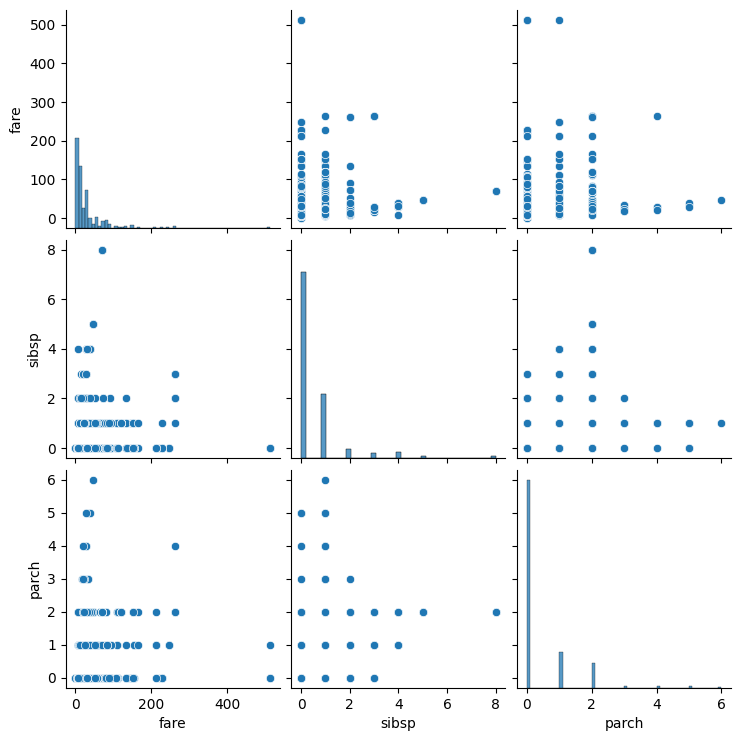

   > Columnas que pasaron el filtro y se graficaron: ['sibsp', 'parch']

2. Test con Lista Específica (columns=['age', 'sibsp']):


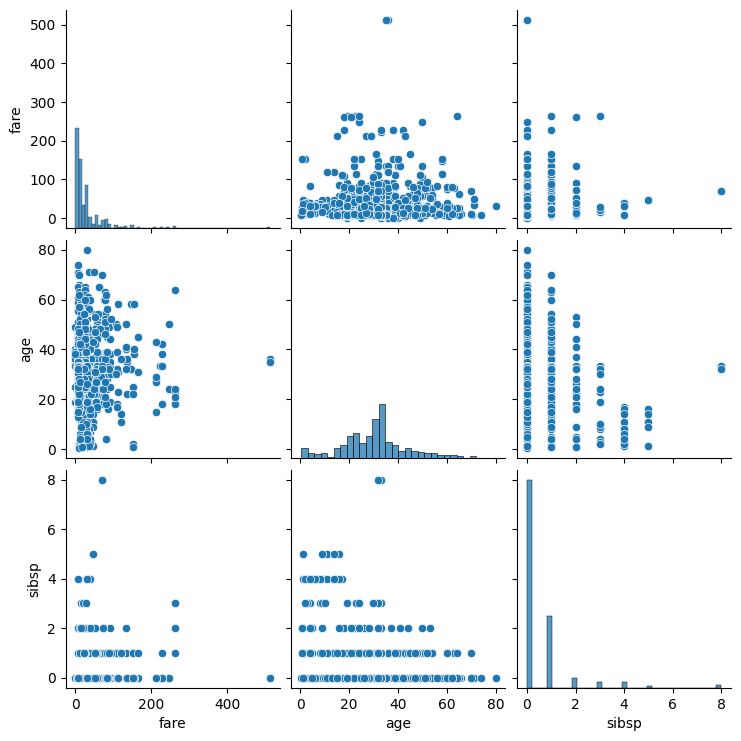

   > Columnas graficadas: ['age', 'sibsp']

3. Test Error (target_col='alive' - Categórico):
Error: La columna 'alive' debe ser numérica.
   > Resultado: None

4. Test Sin Resultados (umbral_corr=0.99):
No hay columnas que cumplan los criterios para graficar.
   > Resultado: []

=== COMPROBACIÓN CATEGÓRICAS PARA REGRESIÓN ===
1. Test Válido (Target: 'fare'):
   > Variables significativas: ['sex', 'sibsp', 'parch', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']

2. Test Error (Target: 'alive'):
Error: La columna 'alive' debe ser numérica.
   > Resultado: None
=== COMPROBACIÓN: PLOT CATEGÓRICAS PARA REGRESIÓN ===



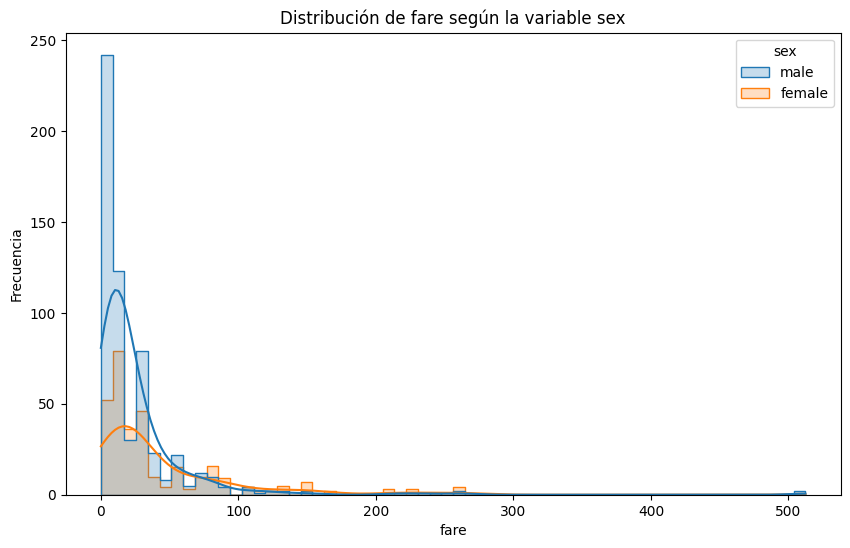

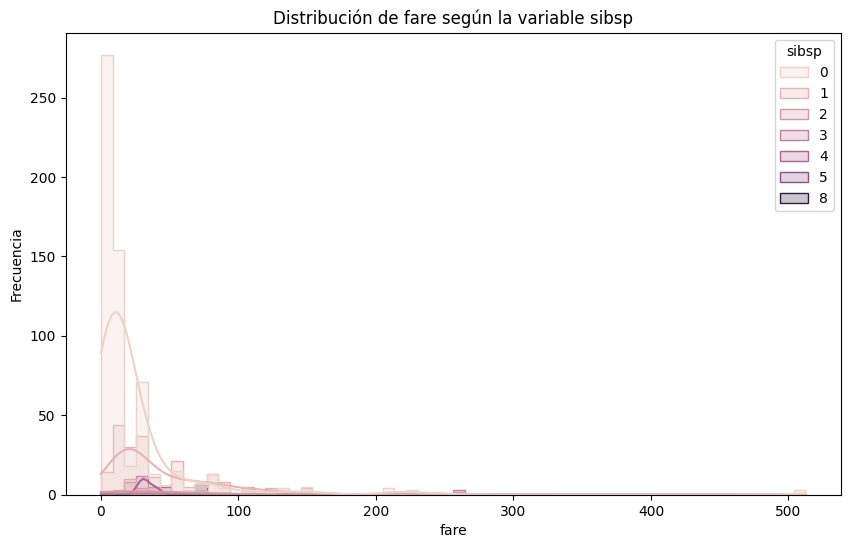

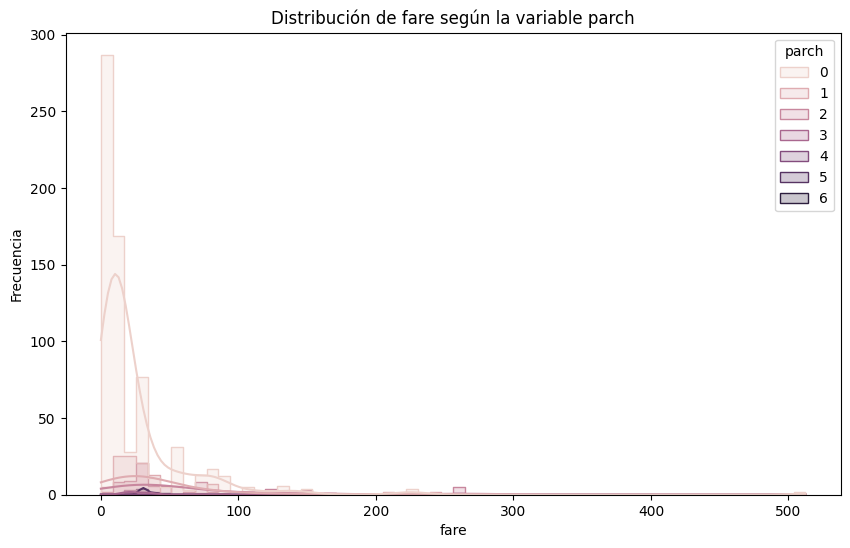

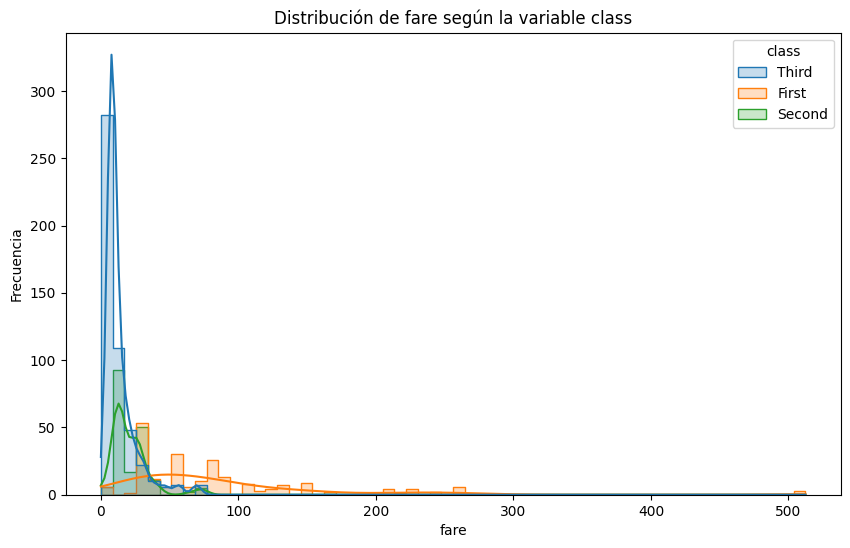

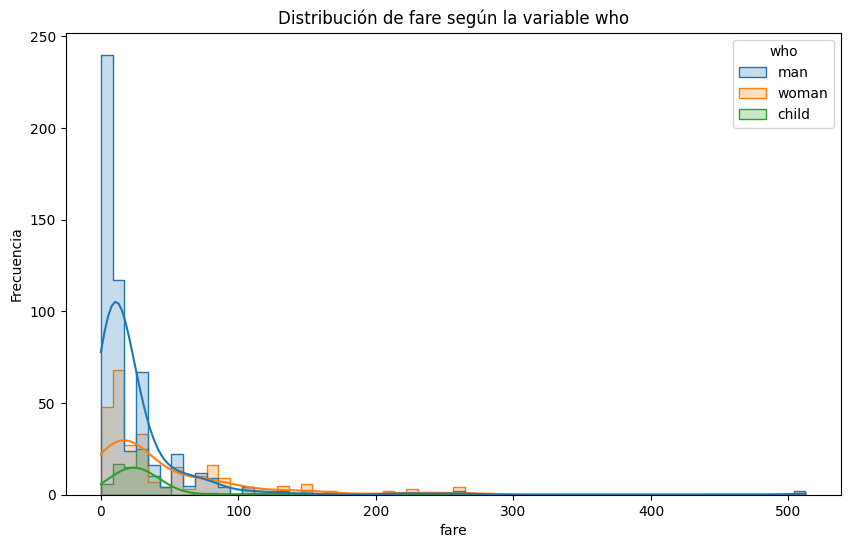

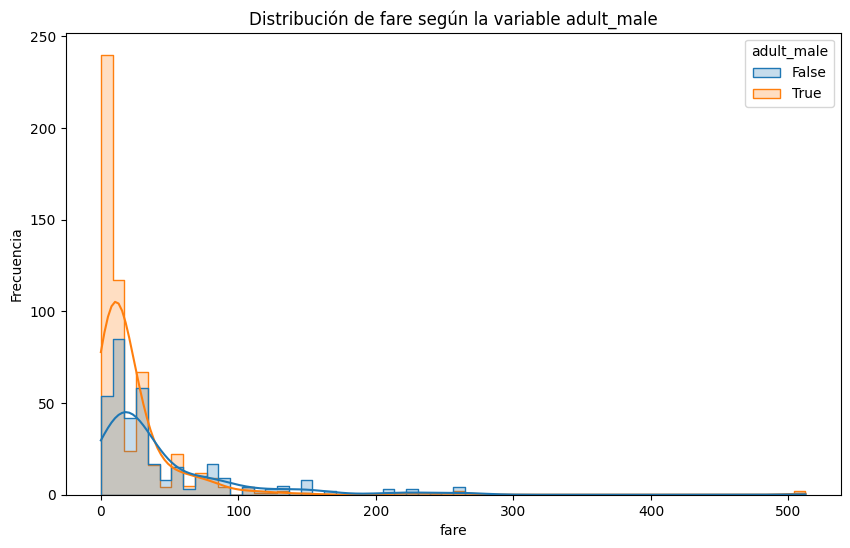

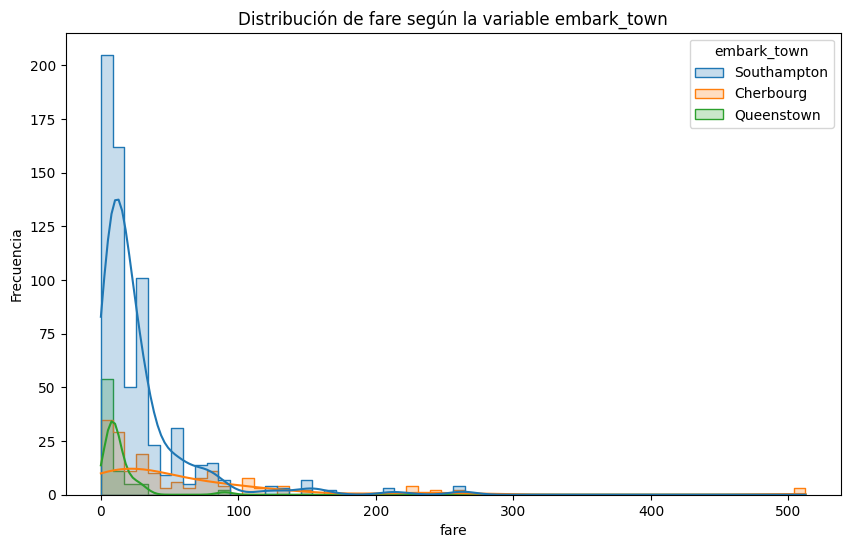

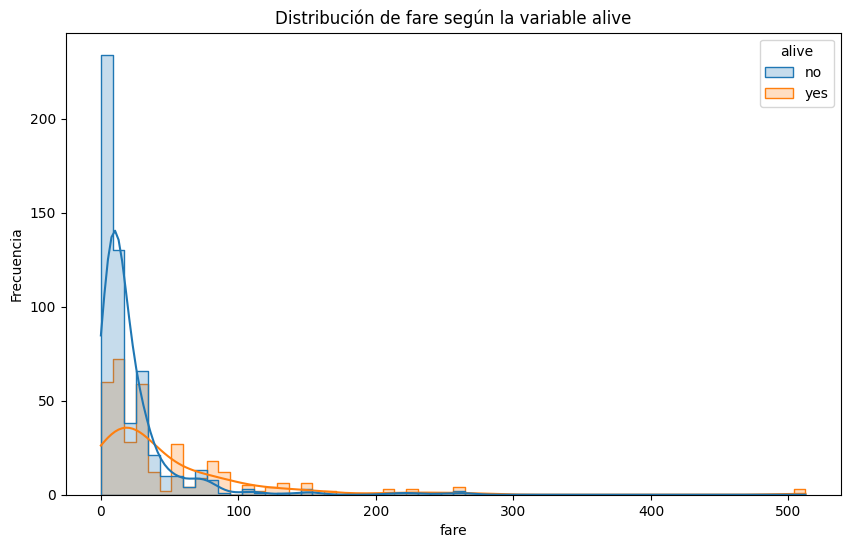

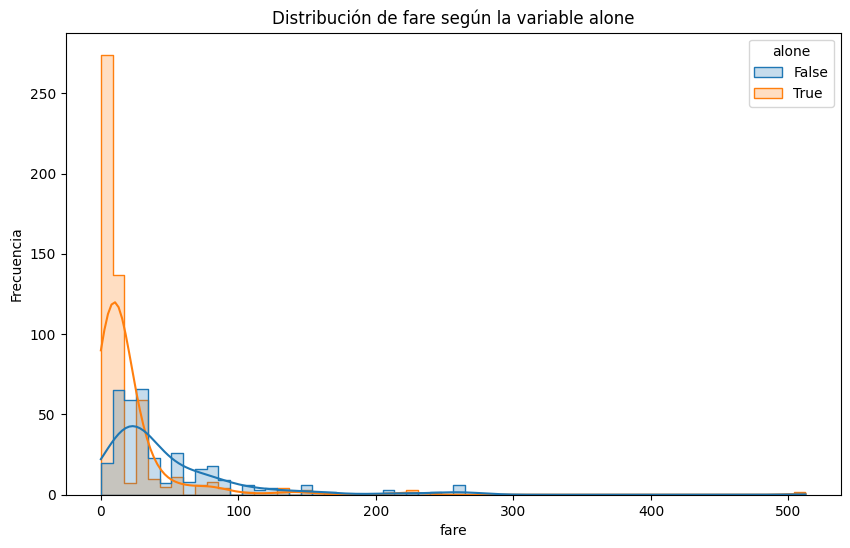


Variables que superaron el test y fueron graficadas: ['sex', 'sibsp', 'parch', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']


In [3]:
import pandas as pd

def describe_df(df):
    """
    Genera un resumen estadístico de las columnas de un DataFrame.

    Argumentos:
    df (pd.DataFrame): El DataFrame que se desea analizar.

    Retorna:
    pd.DataFrame: Un DataFrame donde las columnas son las variables del original 
                  y las filas son: 'DATA_TYPE', 'MISSINGS (%)', 'UNIQUE_VALUES' 
                  y 'CARDINALITY (%)'.
    """
    
    # 1. Obtenemos los tipos de datos (DATA_TYPE)
    tipos = df.dtypes
    
    # 2. Calculamos el porcentaje de nulos (MISSINGS (%))
    # sum() cuenta nulos, se divide por el total y se multiplica por 100
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    # 3. Contamos los valores únicos (UNIQUE_VALUES)
    valores_unicos = df.nunique()
    
    # 4. Calculamos la cardinalidad porcentual (CARDINALITY (%))
    # (Valores únicos / Total de registros) * 100
    cardinalidad = (valores_unicos / len(df)) * 100
    
    # Creamos el DataFrame de resultados uniendo las series anteriores
    resumen = pd.DataFrame({
        'DATA_TYPE': tipos,
        'MISSINGS (%)': missing_pct,
        'UNIQUE_VALUES': valores_unicos,
        'CARDINALITY (%)': cardinalidad
    })
    
    # Transponemos (.T) para que las variables originales queden como columnas
    # tal como se muestra en la imagen de referencia
    return resumen.T

df_titanic = pd.read_csv('./data/titanic.csv')
resultado = describe_df(df_titanic)
print(resultado)

import pandas as pd

def tipifica_variables(df, umbral_categoria, umbral_continua):
    """
    Sugiere el tipo de variable (Binaria, Categórica, Numérica Continua o Discreta)
    basándose en la cardinalidad y un umbral porcentual.

    Argumentos:
    df (pd.DataFrame): El DataFrame cuyas variables se van a clasificar.
    umbral_categoria (int): Límite de valores únicos para considerar una variable como categórica.
    umbral_continua (float): Porcentaje de cardinalidad mínima para considerar una 
                             variable numérica como continua.

    Retorna:
    pd.DataFrame: Un DataFrame con las columnas "nombre_variable" y "tipo_sugerido".
    """
    
    sugerencias = []
    
    for col in df.columns:
        # Calculamos los valores necesarios para la lógica
        cardinalidad = df[col].nunique()
        pct_cardinalidad = (cardinalidad / len(df)) * 100
        
        # Lógica de clasificación
        if cardinalidad == 2:
            tipo = "Binaria"
        elif cardinalidad < umbral_categoria:
            tipo = "Categórica"
        else:
            # Si cardinalidad >= umbral_categoria, evaluamos el porcentaje
            if pct_cardinalidad >= umbral_continua:
                tipo = "Numérica Continua"
            else:
                tipo = "Numérica Discreta"
        
        # Añadimos el resultado a la lista
        sugerencias.append({
            "nombre_variable": col,
            "tipo_sugerido": tipo
        })
    
    # Convertimos la lista de diccionarios en un DataFrame
    return pd.DataFrame(sugerencias)

df_titanic = pd.read_csv('./data/titanic.csv')
sugerencias_df = tipifica_variables(df_titanic, umbral_categoria=10, umbral_continua=5.0)
print(sugerencias_df)

import pandas as pd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Selecciona y visualiza variables numéricas mediante pairplots basándose en correlación
    y significación estadística.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    target_col (str): Columna objetivo para la regresión.
    columns (list): Lista de columnas a evaluar. Si está vacía, usa todas las numéricas.
    umbral_corr (float): Umbral de correlación absoluta (0 a 1).
    pvalue (float): Nivel de significación estadística (alpha).

    Retorna:
    list: Columnas que cumplen los criterios y fueron pintadas.
    """
    
    # 1. Validaciones de entrada
    if not isinstance(df, pd.DataFrame):
        print("Error: El argumento 'df' debe ser un DataFrame.")
        return None
    
    if target_col == "" or target_col not in df.columns:
        print(f"Error: El target_col '{target_col}' no es válido o no existe.")
        return None
    
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna '{target_col}' debe ser numérica.")
        return None

    if not (0 <= umbral_corr <= 1):
        print("Error: 'umbral_corr' debe estar entre 0 y 1.")
        return None

    # 2. Determinar columnas a evaluar
    if not columns:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Aseguramos que el target no se evalúe contra sí mismo
    if target_col in columns:
        columns.remove(target_col)

    # 3. Filtrado de columnas por correlación y p-value
    cols_que_cumplen = []
    
    for col in columns:
        if col not in df.columns:
            continue
            
        # Ignorar si no es numérica
        if not np.issubdtype(df[col].dtype, np.number):
            continue

        df_temp = df[[col, target_col]].dropna()
        if len(df_temp) < 2:
            continue
            
        corr, p_valor = pearsonr(df_temp[col], df_temp[target_col])
        
        if abs(corr) > umbral_corr:
            if pvalue is not None:
                if p_valor <= pvalue:
                    cols_que_cumplen.append(col)
            else:
                cols_que_cumplen.append(col)

    # 4. Visualización (Extra: Máximo 5 columnas por pairplot incluyendo target)
    if not cols_que_cumplen:
        print("No hay columnas que cumplan los criterios para graficar.")
        return []

    # Dividimos la lista en grupos de 4 para que con el target sean máximo 5
    max_cols_por_plot = 4 
    for i in range(0, len(cols_que_cumplen), max_cols_por_plot):
        grupo_columnas = cols_que_cumplen[i:i + max_cols_por_plot]
        columnas_a_pintar = [target_col] + grupo_columnas
        
        sns.pairplot(df[columnas_a_pintar].dropna())
        plt.show()

    return cols_que_cumplen

import pandas as pd

# Asumiendo que las funciones están en archivos independientes o definidas previamente
# from visualizacion_features import plot_features_num_regression

def test_plot_features(df):
    print("=== TEST DE VISUALIZACIÓN (Regresión Numérica) ===\n")

    # CASO 1: Éxito con lista vacía (debe identificar todas las numéricas y filtrar)
    # En el Titanic, esto debería pintar 'fare' vs 'age', 'sibsp', 'parch'.
    print("1. Test Automático (columns=[], umbral_corr=0.1):")
    cols_pintadas = plot_features_num_regression(df, target_col="fare", umbral_corr=0.1)
    print(f"   > Columnas que pasaron el filtro y se graficaron: {cols_pintadas}\n")

    # CASO 2: Éxito con lista específica
    print("2. Test con Lista Específica (columns=['age', 'sibsp']):")
    cols_especificas = plot_features_num_regression(df, target_col="fare", columns=["age", "sibsp"], umbral_corr=0.05)
    print(f"   > Columnas graficadas: {cols_especificas}\n")

    # CASO 3: Error - Target no numérico
    print("3. Test Error (target_col='alive' - Categórico):")
    res_err = plot_features_num_regression(df, target_col="alive")
    print(f"   > Resultado: {res_err}\n")

    # CASO 4: Umbral demasiado alto (Ninguna variable cumple)
    print("4. Test Sin Resultados (umbral_corr=0.99):")
    res_vacio = plot_features_num_regression(df, target_col="fare", umbral_corr=0.99)
    print(f"   > Resultado: {res_vacio}\n")

# Carga de datos
df_titanic = pd.read_csv('./data/titanic.csv')
test_plot_features(df_titanic)

import pandas as pd
import numpy as np
from scipy.stats import f_oneway

def get_features_cat_regression(df, target_col, pvalue=0.05):
    """
    Selecciona variables categóricas que tienen una relación estadísticamente 
    significativa con un target numérico mediante el test ANOVA.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    target_col (str): Nombre de la columna target (debe ser numérica continua).
    pvalue (float): Nivel de significación (alpha). Por defecto 0.05.

    Retorna:
    list: Lista de variables categóricas seleccionadas. 
          Retorna None si los argumentos no son válidos.
    """
    
    # 1. Comprobaciones de tipos y existencia
    if not isinstance(df, pd.DataFrame):
        print("Error: El argumento 'df' debe ser un DataFrame.")
        return None
    
    if target_col not in df.columns:
        print(f"Error: La columna '{target_col}' no existe en el DataFrame.")
        return None
    
    # 2. Comprobar que target_col es numérica continua (según lógica de cardinalidad)
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna '{target_col}' debe ser numérica.")
        return None
    
    cardinalidad_target = df[target_col].nunique()
    pct_cardinalidad = (cardinalidad_target / len(df)) * 100
    
    # Criterio: Más de 10 valores únicos y > 5% de cardinalidad para considerarla "continua"
    if cardinalidad_target < 10 or pct_cardinalidad < 5:
        print(f"Error: La columna '{target_col}' no tiene suficiente cardinalidad para ser target de regresión continua.")
        return None

    if not isinstance(pvalue, (int, float)) or not (0 <= pvalue <= 1):
        print("Error: 'pvalue' debe ser un float entre 0 y 1.")
        return None

    # 3. Identificar columnas categóricas
    # Consideramos categóricas aquellas de tipo object, category o con baja cardinalidad (<10)
    cols_categoricas = []
    for col in df.columns:
        if col == target_col:
            continue
            
        if df[col].dtype == 'object' or df[col].dtype.name == 'category' or df[col].nunique() < 10:
            cols_categoricas.append(col)
    
    features_seleccionadas = []

    # 4. Aplicación del Test ANOVA
    # Comparamos la media del target entre las categorías de cada columna
    for col in cols_categoricas:
        # Limpieza de nulos para el test
        df_temp = df[[col, target_col]].dropna()
        
        # Agrupamos los valores del target por cada categoría de la columna actual
        grupos = [group[target_col].values for name, group in df_temp.groupby(col)]
        
        # El test ANOVA requiere al menos 2 grupos para comparar
        if len(grupos) < 2:
            continue
            
        # Ejecutamos f_oneway (ANOVA de una vía)
        f_stat, p_valor_obtenido = f_oneway(*grupos)
        
        # Si el p-valor es menor que alpha, la variable es significativa
        if p_valor_obtenido <= pvalue:
            features_seleccionadas.append(col)
            
    return features_seleccionadas

# Carga de datos
df_titanic = pd.read_csv('./data/titanic.csv')

print("=== COMPROBACIÓN CATEGÓRICAS PARA REGRESIÓN ===")

# CASO ÉXITO: 'fare' como target numérico. 
# Debería decirnos qué categorías (como 'class' o 'embark_town') influyen en el precio.
print("1. Test Válido (Target: 'fare'):")
res = get_features_cat_regression(df_titanic, target_col="fare", pvalue=0.05)
print(f"   > Variables significativas: {res}\n")

# CASO ERROR: 'alive' como target (es categórica, no apta para esta función de regresión)
print("2. Test Error (Target: 'alive'):")
res_err = get_features_cat_regression(df_titanic, target_col="alive")
print(f"   > Resultado: {res_err}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

def plot_features_cat_regression(df, target_col="", columns=[], pvalue=0.05, with_individual_plot=False):
    """
    Visualiza la distribución de un target numérico frente a variables categóricas
    que superan el test de significación estadística ANOVA.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    target_col (str): Columna objetivo (numérica continua).
    columns (list): Lista de variables categóricas a evaluar. Si vacía, busca automáticamente.
    pvalue (float): Nivel de significación estadística (alpha).
    with_individual_plot (bool): Si True, genera gráficos individuales (reservado para expansión).

    Retorna:
    list: Columnas categóricas que cumplen los criterios y fueron graficadas.
    """
    
    # 1. Validaciones de entrada (Check de valores)
    if not isinstance(df, pd.DataFrame):
        print("Error: El argumento 'df' debe ser un DataFrame.")
        return None
    
    if target_col == "" or target_col not in df.columns:
        print(f"Error: La columna target '{target_col}' no es válida.")
        return None
        
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna '{target_col}' debe ser numérica para regresión.")
        return None

    # Verificación de cardinalidad para asegurar que sea continua/discreta alta
    card_target = df[target_col].nunique()
    if card_target < 10:
        print(f"Error: '{target_col}' no tiene suficiente cardinalidad para este análisis.")
        return None

    # 2. Identificar columnas si la lista está vacía
    if not columns:
        # Buscamos variables con baja cardinalidad o tipo object/category
        columns = [col for col in df.columns if (df[col].dtype == 'object' or df[col].nunique() < 10) and col != target_col]

    cols_seleccionadas = []

    # 3. Test ANOVA y filtrado
    for col in columns:
        if col not in df.columns: continue
            
        df_temp = df[[col, target_col]].dropna()
        grupos = [group[target_col].values for name, group in df_temp.groupby(col)]
        
        if len(grupos) < 2: continue
            
        f_stat, p_valor_obtenido = f_oneway(*grupos)
        
        if p_valor_obtenido <= pvalue:
            cols_seleccionadas.append(col)

    # 4. Visualización: Histogramas agrupados
    if not cols_seleccionadas:
        print("No hay variables categóricas significativas para mostrar.")
        return []

    for col in cols_seleccionadas:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=target_col, hue=col, kde=True, element="step")
        plt.title(f"Distribución de {target_col} según la variable {col}")
        plt.xlabel(target_col)
        plt.ylabel("Frecuencia")
        plt.show()

    return cols_seleccionadas

# Carga de datos
df_titanic = pd.read_csv('./data/titanic.csv')

print("=== COMPROBACIÓN: PLOT CATEGÓRICAS PARA REGRESIÓN ===\n")

# Escenario: Queremos ver qué categorías afectan al precio (fare)
# Debería pintar histogramas para 'sex', 'class', etc., porque el precio varía según estos grupos.
columnas_pintadas = plot_features_cat_regression(df_titanic, target_col="fare", pvalue=0.05)

print(f"\nVariables que superaron el test y fueron graficadas: {columnas_pintadas}")
